# Sensitivity analysis

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

In [5]:
from tqdm.notebook import tqdm

import sys,os
import numpy as np
import pandas as pd
# import matk
import subprocess

from pathlib import Path
from datetime import datetime

In [6]:
from SALib.sample import saltelli, sobol_sequence
import SALib

In [7]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s: %(message)s')

In [8]:
sys.path.append('../../')
import myfunctions.sensitivityAnalysis as sa
import myfunctions.ATSutils as ATSutils
import myfunctions.utils as utils
import myfunctions.colors as mcolors
import myfunctions.general_plots as gp

In [9]:
def cumsum(df_simu, df_obs):
    """compute cumulative sum for ET"""
    time_ind = df_obs.dropna().index
    df_simu_cumsum = df_obs[["mean_ET [mm/8d]"]].dropna().copy()
    for i in np.arange(len(time_ind))[:]:
        itime = time_ind[i]
        if i == 0:
            btime = df_simu.index[0]
        else:
            btime = time_ind[i-1]
        isum = df_simu.loc[btime:itime, 'total evapotranspiration [m d^-1]'].sum()
        df_simu_cumsum.loc[itime, "mean_ET [mm/8d]"] = isum * 1000 # convert m/8d to mm/8d
        
    return df_simu_cumsum

In [10]:
# work_dir = "../model/runs/"
work_dir = "/global/cscratch1/sd/pshuai/coalcreek/model/runs/"
template_file = work_dir + 'model/inputs/forward_run-obs_error/template.xml'
# template_file = '/global/cscratch1/sd/pshuai/east-taylor/PRISM_ensemble_400/template.xml'

base_dir_name = "ens"
fname_log = "sensitivity.log"
fig_dir = "/global/project/projectdirs/m1800/pin/east-taylor/figure/CoalCreek/sensitivity_analysis/"
data_dir ="../data/"
fname_obs_q = data_dir + "USGS/CoalCreek_outlet_discharge.csv"
fname_modis_et = data_dir + "MODIS/CoalCreek_MODIS_ET-2000_2020.csv"
fname_obs_hourly_q = data_dir + "CoalCreek_outlet_hourly_discharge.csv"
fname_grace = data_dir + "coal_creek-GRACE.csv"
fname_gleam = data_dir + "gleam_coal_creek.csv"

result_dir = "/global/project/projectdirs/m1800/pin/east-taylor/results/"

fname_ensemble_csv = work_dir + "PRISM_ensemble_400/ensemble_para.csv"
fname_modis_snowcover = data_dir + "CoalCreek_snowcover.csv"
fname_daymet_p = data_dir + "CoalCreek_daymet_mean_P-1980_2020.csv"
fname_prism_p = data_dir + "CoalCreek_prism_mean_P-2012-2019.csv"
fname_nldas_p = data_dir + "NLDAS_daily_CoalCreek_mean_1980-2020.csv"

watershed_area = 53159325 # m2

## import observation

In [11]:
obs_q = utils.convertUSGSgauge(fname_obs_q, "discharge", datetime_col="dateTime")

obs_et = pd.read_csv(fname_modis_et, index_col='datetime', parse_dates=True)
t_diff = (obs_et.index[1:] - obs_et.index[0:-1]).total_seconds()/86400 # time diff in days
obs_et_daily = obs_et.iloc[1:, 0]/t_diff # averaging ET over 4,5,8 day period

2022-04-21 14:00:01,220 - root - INFO: insert nan


In [10]:
obs_hourly_q = pd.read_csv(fname_obs_hourly_q, index_col = 0, parse_dates = True)
# obs_semiDaily_q = pd.read_csv(fname_obs_semiDaily_q, index_col = 0, parse_dates = True)
# obs_daily_q = pd.read_csv(fname_obs_daily_q, index_col = 0, parse_dates = True)

obs_hourly_q.index = obs_hourly_q.index.shift(5, freq = 'H') # local (UTC-5) to UTC
obs_hourly_q.rename(columns={'discharge [m^3/d]':'watershed boundary discharge [m^3/d]'}, inplace = True)

In [14]:
# shift the daily average to [12h D-1, 11h D+1]
obs_daily_q = obs_hourly_q.resample('D', base = 0.5).mean()

<ipython-input-14-4a6270d53f1e>:2: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  obs_daily_q = obs_hourly_q.resample('D', base = 0.5).mean()


In [11]:
df_modis_snowcover = pd.read_csv(fname_modis_snowcover, parse_dates=['datetime'])
df_modis_snowcover.set_index('datetime', inplace= True)
# modis_snowcover['coverage'] = modis_snowcover['snow cover area (km2)']/ modis_snowcover['snow cover area (km2)'].max()

## generate parameter sets

In [14]:
# specify your low, middle, high ranges
my_param_ranges = {
#                     'priestley_taylor_canopy-evaporation' : [0.3, 0.6, 1.2],
#                    'priestley_taylor_surface-potential_evaporation' : [0.3, 0.6, 1.2],
                   'priestley_taylor_alpha-snow' : [0.3, 0.6, 1.2],    
                   'priestley_taylor_alpha-transpiration' : [0.3, 0.6, 1.2],
                   'snowmelt_rate' : [2.74/2, 2.74, 2.74*2],
                   'snowmelt_degree_diff' : [1, 3, 5], # should be positive?
#                     'manning_n' : [-1.70, -1.2, -0.70] # log10
                   }

In [15]:
# permeabilities are done automatically by reading the default from file, then plus/minus 1 order mag
# my_perm_regions = ['s'+str(i+1) for i in range(5)] + ['g' + str(j+1) for j in range(4)]
my_perm_regions = ['s3', 'g1', 'g4']
# my_perm_regions = ['s3', 's4', 'g1', 'g4'] # used this for 400 ensemble runs

my_perm_param_ranges = sa.create_permeability_param_ranges(my_perm_regions, template_file)

my_param_ranges.update(my_perm_param_ranges)

# note bedrock is done specially, as we don't want min/max format,
# key thing is that middle value is the "control"
# my_param_ranges['perm_bedrock'] = [-14, -16, -12]

my_param_ranges

{'priestley_taylor_alpha-snow': [0.3, 0.6, 1.2],
 'priestley_taylor_alpha-transpiration': [0.3, 0.6, 1.2],
 'snowmelt_rate': [1.37, 2.74, 5.48],
 'snowmelt_degree_diff': [1, 3, 5],
 'perm_s3': [-12.709965388637482, -11.709965388637482, -10.709965388637482],
 'perm_g1': [-13.500312917381596, -12.500312917381596, -11.500312917381596],
 'perm_g4': [-14.0, -13.0, -12.0]}

## create sobol samples

In [14]:
sample_matrix, df_sample = sa.generate_sobol_samples(my_param_ranges, 1000)

df_sample

,priestley_taylor_alpha-snow,priestley_taylor_alpha-transpiration,snowmelt_rate,snowmelt_degree_diff,perm_s3,perm_s4,perm_g1,perm_g4
realization_id,,,,,,,,
1,0.750000,0.750000,3.425000,3.000000,-11.709965,-11.324222,-12.500313,-13.000000
2,0.975000,0.525000,2.397500,2.000000,-11.209965,-10.824222,-13.000313,-12.500000
3,0.525000,0.975000,4.452500,4.000000,-12.209965,-11.824222,-12.000313,-13.500000
4,0.637500,0.637500,3.938750,4.500000,-11.959965,-12.074222,-12.750313,-12.250000
5,1.087500,1.087500,1.883750,2.500000,-10.959965,-11.074222,-11.750313,-13.250000
...,...,...,...,...,...,...,...,...
996,0.666504,0.443262,4.785635,1.957031,-11.274419,-11.134769,-13.283516,-12.076172
997,1.116504,0.893262,2.730635,3.957031,-12.274419,-12.134769,-12.283516,-13.076172
998,0.891504,0.668262,3.758135,2.957031,-11.774419,-11.634769,-12.783516,-13.576172


## generate input files

Write input.xml based on template.xml. This will **not overwrite** existing paths.

In [15]:
sa.gen_model_inputs(my_param_ranges, sample_matrix, start_id = 50, num_sample=400, template_file = template_file, 
                    work_dir= work_dir+"PRISM_ensemble_400/", workdir_base=base_dir_name, logfile = fname_log,
                    landcover_list = ['other', 'Evergreen_Forest', 'Shrub_Scrub', 'Deciduous_Forest'])

2022-01-08 15:11:06,492 - root - INFO: Generated 400 ensembles located at: /global/cscratch1/sd/pshuai/east-taylor/PRISM_ensemble_400/


# Launch jobs

## launch job natively using sbatch

Launch job using a sbatch script. Basically write a for loop and submit entire jobs using `srun`. 

Add `sleep` to be extra safe.

In [ ]:
#!/bin/bash -l

#SBATCH -A PROJECT
#SBATCH -N 152
#SBATCH -t 22:00:00
#SBATCH -L SCRATCH
#SBATCH -J am-batch
#SBATCH --qos premium
#SBATCH -C haswell

module use -a /global/project/projectdirs/m3421/ats-new/modulefiles
module load ats/ecoon-land_cover/cori-haswell/intel-6.0.5-mpich-7.7.10/opt

for i in {3..40}
do
    cd /global/cscratch1/sd/pshuai/yakima/ensemble_run-300m-c128/ens$i
    srun -N 4 -n 128 -e job%J.err -o job%J.out ats --xml_file=input.xml sleep 5 &
done

sleep 1

wait

# Ensemble runs

## postprocess results

In [10]:
obs_q = utils.convertUSGSgauge(fname_obs_q, "discharge")

obs_et = pd.read_csv(fname_modis_et, index_col='datetime', parse_dates=True)
t_diff = (obs_et.index[1:] - obs_et.index[0:-1]).total_seconds()/86400 # time diff in days
obs_et_daily = obs_et.iloc[1:, 0]/t_diff # averaging ET over 4,5,8 day period

2022-02-15 11:36:04,469 - root - INFO: insert nan


In [11]:
sub_obs_et = obs_et.loc["2015-10-01":"2019-10-01", ]

In [12]:
obs_hourly_q = pd.read_csv(fname_obs_hourly_q, index_col = 0, parse_dates = True)
# obs_semiDaily_q = pd.read_csv(fname_obs_semiDaily_q, index_col = 0, parse_dates = True)
# obs_daily_q = pd.read_csv(fname_obs_daily_q, index_col = 0, parse_dates = True)

obs_hourly_q.index = obs_hourly_q.index.shift(5, freq = 'H') # local (UTC-5) to UTC
obs_hourly_q.rename(columns={'discharge [m^3/d]':'watershed boundary discharge [m^3/d]'}, inplace = True)

In [13]:
# shift the daily average to [12h D-1, 11h D+1]
obs_daily_q = obs_hourly_q.resample('D', offset = 0.5).mean()

In [14]:
# for var in para_df.columns[0:-1]:
# #     var = "perm_bedrock"
#     parms, index = np.unique(para_df[var], return_index=True)
#     assert(len(parms) == 3)
#     assert( 0 in index) # 0 is the base case
    
# fig, ax = plt.subplots(1,1, figsize=(8,4))

output_variables = ["watershed boundary discharge [m^3/d]", "total evapotranspiration [mm d^-1]",
               'snowmelt [mm d^-1]', 'SWE [m]']
# var = "watershed boundary discharge [m^3/d]"
# for j in range(len(output_variables)):
# output = output_variables[j]

# ax = axes.flatten()[j]
# df_q = obs_q[["Flow [m^3/day]"]].loc["2015-10-01":"2019-10-02", :]
# df_q.columns = ['obs discharge [m^3/d]']
df_q = pd.DataFrame({'datetime':pd.date_range("2015-10-01","2019-10-02")})
df_q.set_index('datetime', inplace=True, drop = True)

df_et = obs_et_daily.loc["2015-10-01":"2019-10-02"]
df_et = df_et.to_frame(name = "obs ET [mm/d]")

df_sm = pd.DataFrame({'datetime':pd.date_range("2015-10-01","2019-10-02")})
df_sm.set_index('datetime', inplace=True, drop = True)
df_swe = df_sm.copy()

In [16]:
lst  =[]
for i in tqdm(np.arange(51,450)):
#     idx = para_df.index[i]
    idir = work_dir + "PRISM_ensemble_400/"  + base_dir_name + "." + str(i) + "/"
    try:
        idf = ATSutils.load_waterBalance(idir, WB_filename="water_balance-daily.dat", canopy = True, plot = False)
    except:
        logging.info(f"ensemble: {i} did not start") 
        continue
    
    if idf.index[-1] < datetime(2019,10,1):
        lst.append(i)

    
    for var in output_variables:
        if var == "watershed boundary discharge [m^3/d]":    
            df_q = pd.merge(df_q, idf[[var]], how='outer', left_index=True, right_index=True)
            df_q.rename(columns={var:base_dir_name + "." + str(i)}, inplace = True)
        elif var == "total evapotranspiration [mm d^-1]":
            df_et = pd.merge(df_et, idf[[var]], how='outer', left_index=True, right_index=True)
            df_et.rename(columns={var:base_dir_name + "." + str(i)}, inplace = True)
        elif var == 'snowmelt [mm d^-1]':
            df_sm = pd.merge(df_sm, idf[[var]], how='outer', left_index=True, right_index=True)
            df_sm.rename(columns={var:base_dir_name + "." + str(i)}, inplace = True)
        elif var == 'SWE [m]':
            df_swe = pd.merge(df_swe, idf[[var]], how='outer', left_index=True, right_index=True)
            df_swe.rename(columns={var:base_dir_name + "." + str(i)}, inplace = True)  
        else:
            raise KeyError("variable not implemented.")

if len(lst) > 0:
    logging.info(f"ensembles: {lst} did not finish")            

  0%|          | 0/399 [00:00<?, ?it/s]

2022-02-15 11:44:04,292 - root - INFO: ensemble: 447 did not start
2022-02-15 11:44:04,299 - root - INFO: ensemble: 448 did not start
2022-02-15 11:44:04,309 - root - INFO: ensemble: 449 did not start


In [17]:
# use shifted USGS streamflow as obs data
df_q['obs discharge [m^3/d]'] = obs_daily_q.loc['2015-10-01':'2019-10-02', 'watershed boundary discharge [m^3/d]'].values

/tmp/ipykernel_64968/1620480137.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_q['obs discharge [m^3/d]'] = obs_daily_q.loc['2015-10-01':'2019-10-02', 'watershed boundary discharge [m^3/d]'].values


In [18]:
if len(lst) > 0:
    for i in lst:
        icol = base_dir_name + "." + str(i)
        df = df_q[[icol]].dropna()
        print(i, df.index[-1])

## plot ensemble

In [12]:
# df_q = pd.read_csv(result_dir + "ensemble_run/ens_knl/ensemble_q_all_396.csv", index_col = 0, parse_dates=True)
# df_et = pd.read_csv(result_dir + "ensemble_run/ens_knl/ensemble_ET_all_396.csv", index_col = 0, parse_dates=True)

### calculate composite ET

The 8-day ET (0.1mm/8days or 0.1mm/5days) is the sum of ET during these 8-day time periods
(5 days for 361 composite data in 2001, 2002, 2003, 2005, 2006, 2007, 2009, 2010, 6 days for
361 in 2000, 2004, 2008). 

see [Mu et al., ](http://files.ntsg.umt.edu/data/NTSG_Products/MOD16/MOD16_global_evapotranspiration_description.pdf) for detailed description.

In [19]:
dates = ["2015-10-01", "2019-10-01"]

In [20]:
# time_ind = df_et.dropna().index
time_ind = obs_et.loc[dates[0]:dates[1], :].index

# df_8d_et = df_et.dropna().copy()
df_8d_et = df_et.loc[time_ind, ].copy()
for i in np.arange(len(time_ind))[:]:
    itime = time_ind[i]
    if i == 0:
        btime = df_et.index[0]
    else:
        btime = time_ind[i-1]
        
    istart = list(df_et.index).index(btime)
    iend = list(df_et.index).index(itime)    
    # `loc` includes both ends, but `iloc` does not include end bound!
    isum = df_et.iloc[istart:iend+1, :].sum(min_count = 1) # return NA is sum() contains NA
    df_8d_et.loc[itime, :] = isum.values

In [21]:
df_8d_et['obs ET [mm/8d]'] = obs_et.loc[time_ind[0] : time_ind[-1], 'mean_ET [mm/8d]'].values
df_8d_et.drop(columns = ['obs ET [mm/d]'], inplace = True)

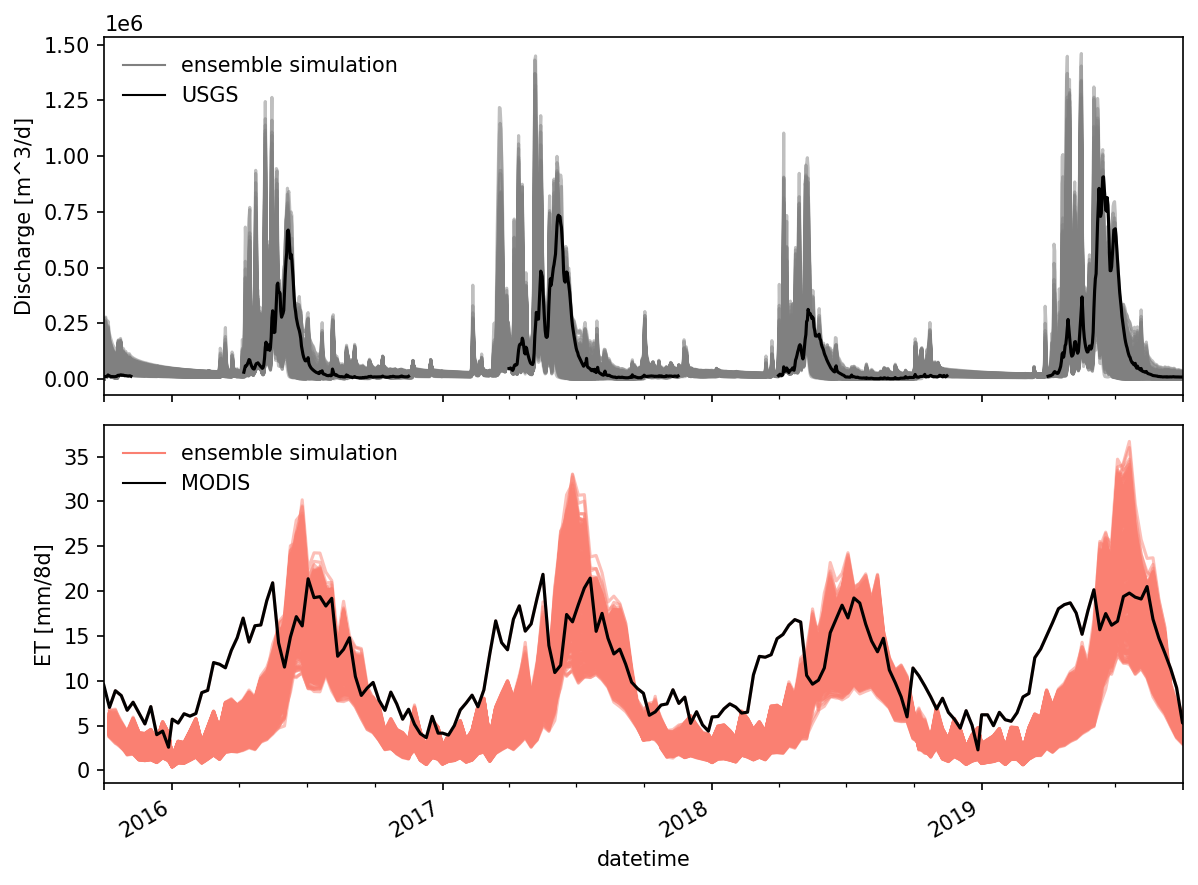

In [22]:
fig, axes = plt.subplots(2,1, figsize=(8,6), sharex = True)

ax = axes[0]
df_q.plot(ax = ax, color = 'gray', alpha = 0.5)
df_q['obs discharge [m^3/d]'].plot(color = 'k', zorder = 99, ax = ax)
ax.legend('')
utils.custom_legend(['gray', 'k'], ['ensemble simulation', 'USGS'], ax = ax)
ax.set_ylabel("Discharge [m^3/d]")

ax = axes[1]
# df_et.plot(ax = ax, color = 'salmon', alpha = 0.5)
df_8d_et.plot(ax = ax, color = 'salmon', alpha = 0.5)

# ax.plot(obs_et_daily.index, obs_et_daily.values, color = 'k', zorder = 99)
ax.plot(obs_et.index, obs_et['mean_ET [mm/8d]'].values, color = 'k', zorder = 99)

ax.legend('')
utils.custom_legend(['salmon', 'k'], ['ensemble simulation', 'MODIS'], ax = ax)
ax.set_ylabel("ET [mm/8d]")
ax.set_xlim([datetime(2015,10,1), datetime(2019,10,1)])

fig.autofmt_xdate()
fig.tight_layout()

### save to file

In [24]:
name = "ensemble_run/prism_400"
df_q.to_csv(result_dir + f"{name}/ensemble_daily_q_all.csv")
df_et.to_csv(result_dir + f"{name}/ensemble_daily_ET_all.csv")
df_sm.to_csv(result_dir + f"{name}/ensemble_daily_snowmelt_all.csv")
df_swe.to_csv(result_dir + f"{name}/ensemble_daily_SWE_all.csv")

df_8d_et.to_csv(result_dir + f"{name}/ensemble_8d_ET_all.csv")

In [28]:
# df_q = pd.read_csv(result_dir + "ensemble_run/ens_knl/ensemble_q_all_396.csv", index_col = 0)

# # use shifted USGS streamflow as obs data
# df_q['obs discharge [m^3/d]'] = obs_daily_q.loc['2015-10-01':'2019-10-02', 'watershed boundary discharge [m^3/d]'].values

# df_q.to_csv(result_dir + "ensemble_run/ens_knl/ensemble_q_all_396.csv")

### snow cover data

In [9]:
# df_q = pd.read_csv(result_dir + "ensemble_run/ens_knl/ensemble_q_all_396.csv", index_col=0)

In [10]:
# df_q.dropna(axis = 1, inplace = True)

In [25]:
df_modis_snowcover = pd.read_csv(fname_modis_snowcover, index_col='datetime')
df_modis_snowcover = df_modis_snowcover[["snow cover pct [-]"]]
df_modis_snowcover = df_modis_snowcover.loc[dates[0] : dates[1]]
df_modis_snowcover.index = pd.to_datetime(df_modis_snowcover.index)

In [27]:
df_snow_cover = pd.DataFrame({'datetime':pd.date_range(dates[0], dates[1])})
df_snow_cover.set_index('datetime', inplace=True, drop = True)

# i = 1
for i in tqdm(df_q.columns[:-1]):
    
    # if i not in ['ens.7']:
    idir = work_dir + "PRISM_ensemble_400/"  + i + "/"
    df = ATSutils.get_snow_cover(idir)

    df_snow_cover = pd.merge(df_snow_cover, df[["snow_cover_pct [-]"]], how='outer', left_index=True, right_index=True)
    df_snow_cover.rename(columns={"snow_cover_pct [-]":i}, inplace = True)

  0%|          | 0/396 [00:00<?, ?it/s]

In [28]:
df_snow_cover

,ens.51,ens.52,ens.53,ens.54,ens.55,ens.56,ens.57,ens.58,ens.59,ens.60,...,ens.437,ens.438,ens.439,ens.440,ens.441,ens.442,ens.443,ens.444,ens.445,ens.446
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_snow_cover = pd.merge(df_modis_snowcover[["snow cover pct [-]"]], df_snow_cover, how='outer', left_index=True, right_index=True)
df_snow_cover.rename(columns={'snow cover pct [-]':'MODIS snowcover [-]'}, inplace = True)

In [35]:
df_snow_cover.to_csv(result_dir + f"{name}/ensemble_daily_snowcover_all.csv")

Text(0, 0.5, 'Snowcover percentage [-]')

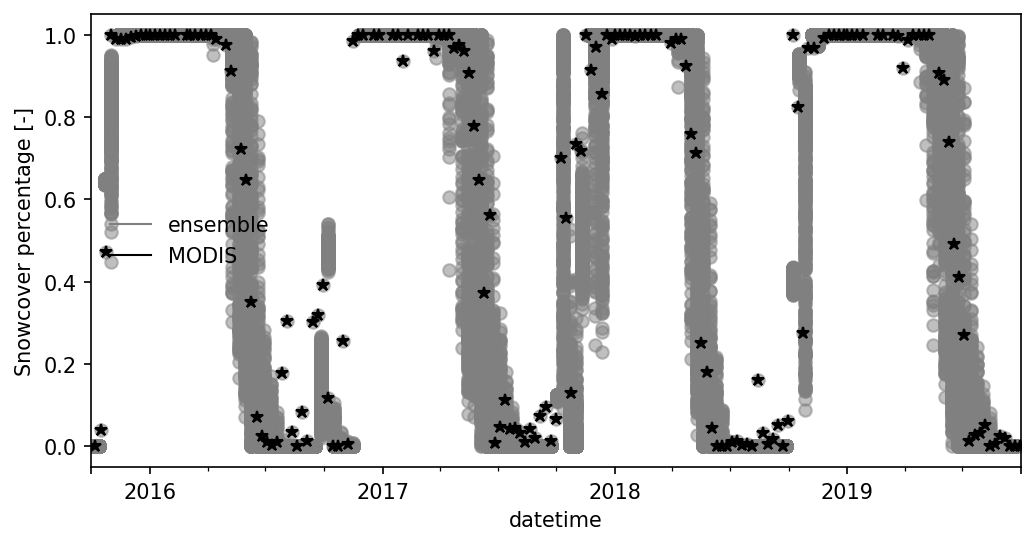

In [41]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

df_snow_cover.plot(ax=ax,color = 'gray', kind='line', style='o', alpha = 0.5)
# df_snow_cover[['MODIS snowcover [-]']].plot(ax=ax, kind = 'scatter', color = 'k')
ax.plot(df_snow_cover.index, df_snow_cover['MODIS snowcover [-]'], '*--k')

ax.legend('')
utils.custom_legend(['gray', 'k'], ['ensemble', 'MODIS'], ax = ax, loc = 'best')
ax.set_ylabel("Snowcover percentage [-]")

Merge with MODIS 8-day maximum snowcover. Here we recalculate the 8-day maximum snowcover from ATS using snow cover data during 8-day period.

In [11]:
# df_snow_cover = pd.read_csv(result_dir + "ensemble_run-400/ensemble_daily_snowcover_all.csv", index_col='datetime', parse_dates=['datetime'])

In [42]:
time_ind = df_modis_snowcover.index

df_8d_snowcover = df_snow_cover.loc[time_ind].copy()
# df_8d_snowcover.pop('MODIS snowcover [-]')
for i in np.arange(len(time_ind))[:]:
    itime = time_ind[i]
    if i == 0:
        btime = df_snow_cover.index[0]
    else:
        btime = time_ind[i-1]
        
    istart = list(df_snow_cover.index).index(btime)
    iend = list(df_snow_cover.index).index(itime)
    # `loc` includes both ends, but `iloc` does not include end bound!
    imax = df_snow_cover.iloc[istart+1:iend+1, :].max(axis = 0) # return NA is sum() contains NA
    df_8d_snowcover.loc[itime, :] = imax.values

In [44]:
df_8d_snowcover['MODIS snowcover [-]'] = df_modis_snowcover['snow cover pct [-]'].values
# df_8d_et.drop(columns = ['obs ET [mm/d]'], inplace = True)

Text(0, 0.5, 'Snowcover percentage [-]')

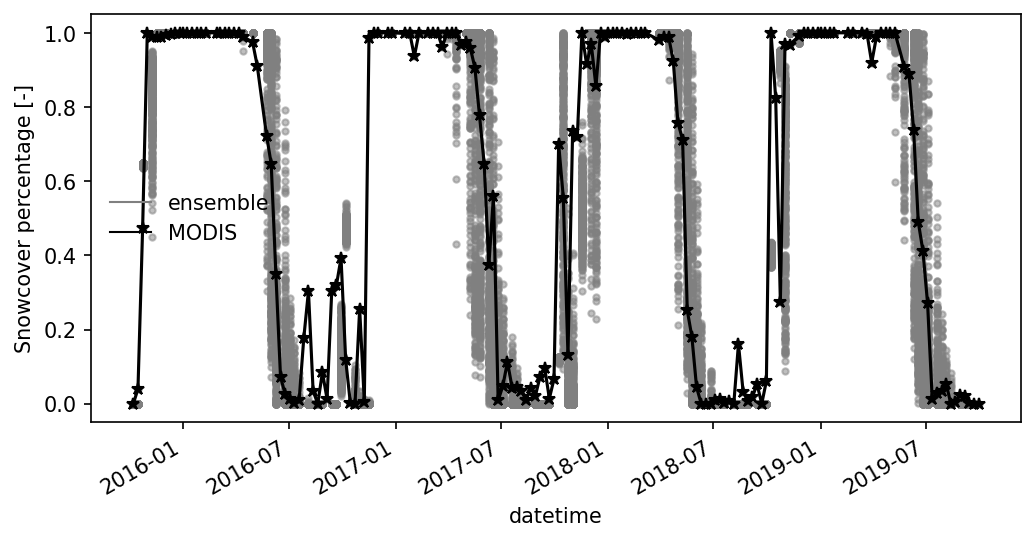

In [45]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

df_8d_snowcover.plot( ax=ax,color = 'gray', alpha = 0.5, marker='.', linestyle='none')
ax.plot(df_8d_snowcover.index, df_8d_snowcover['MODIS snowcover [-]'], '*-k')

ax.legend('')
utils.custom_legend(['gray', 'k'], ['ensemble', 'MODIS'], ax = ax, loc = 'best')
ax.set_ylabel("Snowcover percentage [-]")

In [46]:
df_8d_snowcover.to_csv(result_dir + f"{name}/ensemble_8d_snowcover_all.csv")